In [1]:
from kineticmodel import SRTM_Zhou2003, SRTM_Lammertsma1996

In [2]:
import sys, os
sys.path.insert(0,os.pardir)
from tests.generate_test_data import generate_fakeTAC_SRTM

In [3]:
import numpy as np
np.random.seed(0)

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
% matplotlib inline

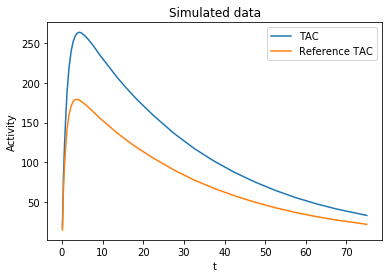

In [4]:
# generate noiseless fake data based on SRTM
BP = 0.5
R1 = 1.2
t, dt, TAC, refTAC = generate_fakeTAC_SRTM(BP, R1)

numFrames = len(t)

fig, ax = plt.subplots();
ax.plot(t, TAC, label='TAC');
ax.plot(t, refTAC, label='Reference TAC');
ax.set_xlabel('t');
ax.set_ylabel('Activity');
ax.set_title('Simulated data');
ax.legend();

In [5]:
# Generate "image" data
# Assume that entire "image" corresponds to a region with uniform BP and R1 values

imdim = (5,5,5)
numVoxels = np.prod(imdim)

# Generate noisy simulations by adding normal noise -- I don't think this is a good way
pct_noise = 1

TAC_matrix = TAC + np.random.normal(0,np.outer(TAC,np.repeat(pct_noise, numVoxels)/100).T)

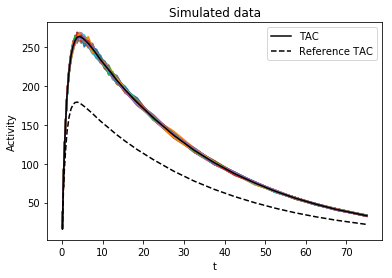

In [6]:
fig, ax = plt.subplots();
ax.plot(t, TAC_matrix.T, label='');
ax.plot(t, TAC, 'k-', label='TAC');
ax.plot(t, refTAC, 'k--', label='Reference TAC');
ax.set_xlabel('t');
ax.set_ylabel('Activity');
ax.set_title('Simulated data');
ax.legend();

In [7]:
# Initialize SRTM Lammerstma 1996 model
mdl_lammertsma = SRTM_Lammertsma1996(t, dt, TAC_matrix, refTAC)

# fit model
mdl_lammertsma.fit();

In [8]:
# Initialize SRTM Zhou 2003 model
mdl_zhou = SRTM_Zhou2003(t, dt, TAC_matrix, refTAC)

mdl_zhou.fit();

In [9]:
# we now take advantage of the spatial constraint capabilities of Zhou model

# Initialize SRTM Zhou 2003 model
mdl_zhou_spatial_constraint = SRTM_Zhou2003(t, dt, TAC_matrix, refTAC)

# we first reorganize the TAC data in a 4-D matrix and apply Gaussian smoothing to 
# each time frame

TAC_img = np.reshape(TAC_matrix, (*imdim,numFrames))

sigma = 5

smoothTAC_img = np.zeros_like(TAC_img)
for k in range(TAC_matrix.shape[-1]):
    smoothTAC_img[:,:,:,k] = gaussian_filter(TAC_img[:,:,:,k],sigma=sigma)

smoothTAC_matrix = np.reshape(smoothTAC_img, TAC_matrix.shape)

mdl_zhou_spatial_constraint.fit(smoothTAC=smoothTAC_matrix);

# Refine R1
img_R1 = np.reshape(mdl_zhou_spatial_constraint.results['R1'], imdim)
img_k2 = np.reshape(mdl_zhou_spatial_constraint.results['k2'], imdim)
img_k2a = np.reshape(mdl_zhou_spatial_constraint.results['k2a'], imdim)
img_noiseVar_eqR1 = np.reshape(mdl_zhou_spatial_constraint.results['noiseVar_eqR1'], imdim)

smooth_img_R1 = gaussian_filter(img_R1,sigma=sigma)
smooth_img_k2 = gaussian_filter(img_k2,sigma=sigma)
smooth_img_k2a = gaussian_filter(img_k2a,sigma=sigma)

smooth_R1 = smooth_img_R1.flatten()
smooth_k2 = smooth_img_k2.flatten()
smooth_k2a = smooth_img_k2a.flatten()

# get h
m = 3
h = np.zeros((numVoxels, m))
h[:,0] = gaussian_filter(m * img_noiseVar_eqR1 / np.square(img_R1 - smooth_img_R1),
                         sigma=sigma).flatten()
h[:,1] = gaussian_filter(m * img_noiseVar_eqR1 / np.square(img_k2 - smooth_img_k2),
                         sigma=sigma).flatten()
h[:,2] = gaussian_filter(m * img_noiseVar_eqR1 / np.square(img_k2a - smooth_img_k2a),
                         sigma=sigma).flatten()

mdl_zhou_spatial_constraint.refine_R1(smooth_R1,smooth_k2,smooth_k2a,h)

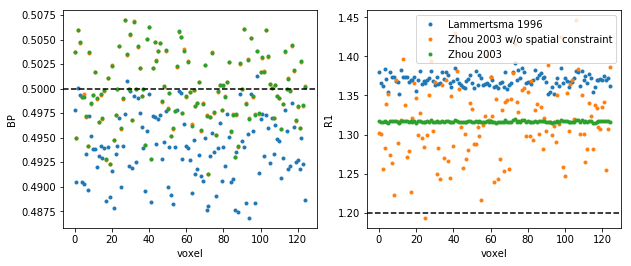

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,4));

axes[0].plot(mdl_lammertsma.results['BP'], '.', label='Lammertsma 1996');
axes[0].plot(mdl_zhou.results['BP'], '.', label='Zhou 2003 w/o spatial constraint');
axes[0].plot(mdl_zhou_spatial_constraint.results['BP'], '.', label='Zhou 2003');
axes[0].axhline(y=BP, color='k', linestyle='--');
axes[0].set_xlabel('voxel');
axes[0].set_ylabel('BP');
#axes[0].legend();

axes[1].plot(mdl_lammertsma.results['R1'], '.', label='Lammertsma 1996');
axes[1].plot(mdl_zhou.results['R1'], '.', label='Zhou 2003 w/o spatial constraint');
axes[1].plot(mdl_zhou_spatial_constraint.results['R1_lrsc'], '.', label='Zhou 2003');
axes[1].axhline(y=R1, color='k', linestyle='--');
axes[1].set_xlabel('voxel');
axes[1].set_ylabel('R1');
axes[1].legend();